In [2]:
# Basic building-block packages
import numpy as np
from numpy import heaviside as th

# For numerical solutions of ODEs
from scipy.integrate import solve_ivp

# Some fancy-smancy maths!! (not really)
from scipy.stats import linregress
from numpy.linalg import norm
import scipy.fftpack as fft

# For pretty-pretty graphs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

# Quality of life shit
from tqdm import tqdm
import pickle



def NIC(x,a,b,B):
    g = -a*x*(th(x+B,1)-th(x-B,1)) # Centre
    g += (b*x+(a+b)*B)*th(-x-B,1) # Lefterior
    g += (b*x-(a+b)*B)*th(x-B,1) # Righterior
    return g

def Chua(x,a1,b1,B1,a2,b2,B2):
    return NIC(x,a1,b1,B1)+NIC(x,a2,b2,B2)

def sys_DE(t,w,inte,exte,circ):
    """
    Defines Chua's equations

    Arguments:
        w :  vector of the state variables:
                  w = [x,y,z]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x,y,z = w
    R,C1,C2,L,F,freq = circ
    dx = ((y-x)/R-Chua(x,*inte,*exte))/C1
    dy = ((x-y)/R+z)/C2
    dz = -y/L-(F*np.sin(2*np.pi*freq*t))/L
    return dx,dy,dz

def standardise(x,y,z,t,step=1):
    z = ((z[:-1]-z[1:])/(t[:-1]-t[1:])*L)[::step]
    x = x[1::step]
    y = y[1::step]
    t = t[1::step]
    return x,y,z,t

In [ ]:
# Check Diode function

Vin = np.linspace(-9,9,100)
Y1 = [NIC(x,*interior) for x in Vin]
Y2 = [NIC(x,*exterior) for x in Vin]
Y0 = [Chua(x,*interior,*exterior) for x in Vin]

for Vout in [Y1,Y2]:
    plt.scatter(Vin,Vout
             ,s=1
             )

plt.scatter(Vin,Y0
            ,s=1
            ,color="green")
plt.grid()

## Integration method 1

In [ ]:
# Parameters 

plt.close("all")

R = 2500
C1 = 10e-9
C2 = 100e-9
L = 15e-3

R2,R3 = 220,2200
R4,R6 = 22000,3300
A = 1000; E = 9

F,freq = 0,100

interior = [((A-1)*R2+R3)/(R2*(R2+(1+A)*R3))
            ,1/R2,
            (R2+(1+A)*R3)/(A*(R2+R3))*E]
exterior = [((A-1)*R4+R6)/(R4*(R4+(1+A)*R6))
            ,1/R4
            ,(R4+(1+A)*R6)/(A*(R4+R6))*E]

print(interior,"\n",exterior)

def NIC(x,a,b,B):
    g = -a*x*(th(x+B,1)-th(x-B,1)) # Centre
    g += (b*x+(a+b)*B)*th(-x-B,1) # Lefterior
    g += (b*x-(a+b)*B)*th(x-B,1) # Righterior
    return g

def Chua(x,a1,b1,B1,a2,b2,B2):
    return NIC(x,a1,b1,B1)+NIC(x,a2,b2,B2)

# Numerical interation method 1

dt = 2e-7; duration = 1e7
print(f"Simulation of {dt*duration}s.")

X,Y,Z = [0],[3],[0]
for i in tqdm(range(int(duration))):
    t = i*dt

    xi,yi,zi = X[-1],Y[-1],Z[-1]

    dx = (yi-xi)/R-Chua(xi,*interior,*exterior)
    dy = (xi-yi)/R+zi
    dz = -yi+F*np.sin(2*np.pi*freq*t)
    # dz = -yi
    X.append(xi+dx/C1*dt);Y.append(yi+dy/C2*dt);Z.append(zi+dz/L*dt)

t = [t*dt for t in range(int(duration+1))]

# Plot the solutions

"""
If the plot that this code block shows is not pleasing for you, don't 
repeat the simulation in this code block, but instead move on to the b
lock below and use the code there to manipulate the data. 

- Kachow
"""

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(2,2,wspace=0.1,)

axs1 = fig.add_subplot(grid[0,0], projection='3d')
axs2 = plt.subplot(grid[0,1])
axs3 = plt.subplot(grid[1,:])

axs1.scatter(X[::100],Y[::100],Z[::100]
               ,s=0.003
               )
axs1.scatter(X[0],Y[0],Z[0]
               ,s=10
               )

for var in tqdm([X,Y,Z]):
    axs3.scatter(t, var,s=0.3)

fig.savefig("../figures/phase_space")

## Integration method 2

by solve_ivp from scipy

In [55]:
# Numerical integration by solve_ivp

R = 1000
C1 = 10e-9
C2 = 100e-9
L = 25e-3

R2,R3 = 220,2200
R4,R6 = 22000,3300
A = 1000; E = 9

F = 0.

interior = [((A-1)*R2+R3)/(R2*(R2+(1+A)*R3))
            ,1/R2,
            (R2+(1+A)*R3)/(A*(R2+R3))*E]
exterior = [((A-1)*R4+R6)/(R4*(R4+(1+A)*R6))
            ,1/R4
            ,(R4+(1+A)*R6)/(A*(R4+R6))*E]

t_span = (0,.10)
t_eval = np.linspace(*t_span,int(1e7)) # No need to be so fine like here. 
xyz0 = [0.,0.1,0.001] # Recall that z is in Amperes (a large unit).

Circ = [[1892,C1,C2,L,0,0],[1893,C1,C2,L,0,0],[1894,C1,C2,L,0,0]]

data = {0: "NA",1:"NA",2:"NA"}

for i, circ in enumerate(Circ):

    solution = solve_ivp(sys_DE,t_span,xyz0,t_eval=t_eval,first_step=1e-7,
                        args=[interior,exterior,circ])

    x_sol = solution.y[0]; y_sol = solution.y[1]; z_sol = solution.y[2]
    time = solution.t

    data[i] = solution

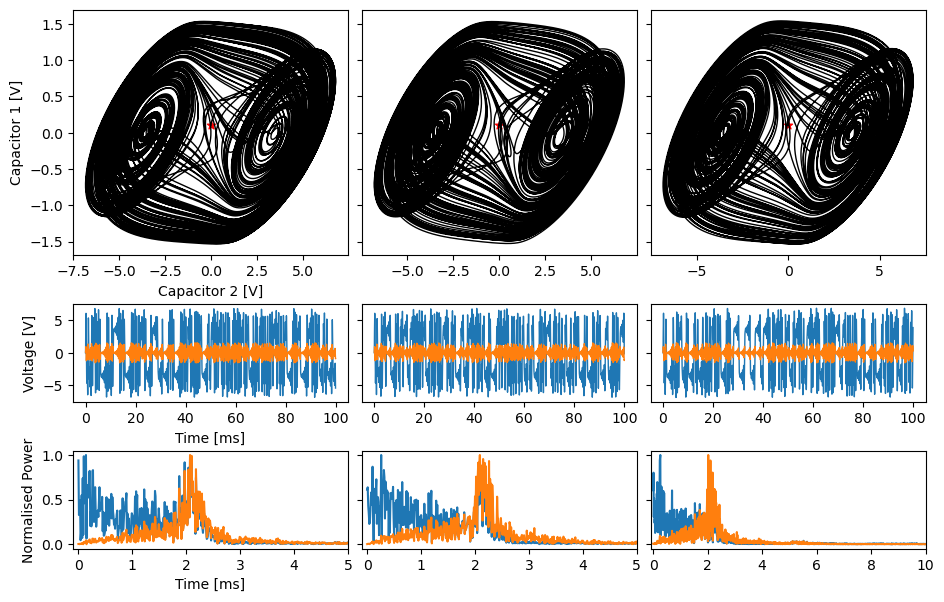

In [56]:
fig,axs = plt.subplots(3,3,figsize=(11,7)
                       ,sharey="row",height_ratios=[2.5,1,1])
fig.subplots_adjust(wspace=0.05,hspace=0.33)

for i in range(3):
    solution = data[i]
    x_sol = solution.y[0]; y_sol = solution.y[1]
    time = solution.t

    if i==0:
        frc = int(len(time)/1); div = 100
    elif i==1:
        frc = int(len(time)/1); div = 100
    else:
        frc = int(len(time)/1); div = 100

    x_sol = x_sol[:frc:div]
    y_sol = y_sol[:frc:div]
    time = time[:frc:div]

    fourier = [np.abs(fft.fft(sol)) for sol in [x_sol,y_sol]] 
    fourier = [fou/np.max(fou) for fou in fourier]
        
    tau = time[1]-time[0] # time interval

    freq = fft.fftfreq(len(x_sol), tau)

    axs[0,i].plot(x_sol,y_sol
                ,linewidth=1,color="k"
                )
    axs[0,i].scatter(x_sol[0],y_sol[0]
                ,marker="*",color="r"
                )

    for var in [x_sol,y_sol]:
        axs[1,i].plot(time*1000, var,linewidth=1)

    for j in range(2): 
        axs[2,i].plot(freq[freq>=0]/1000, fourier[j][freq>=0])
    
    if i==0:
        axs[2,i].set_xlim(-.1,5)
    elif i==1:
        axs[2,i].set_xlim(-.1,5)
    else:
        axs[2,i].set_xlim(-.1,10)
    
axs[0,0].set_ylabel("Capacitor 1 [V]")
axs[0,0].set_xlabel("Capacitor 2 [V]")

axs[1,0].set_ylabel("Voltage [V]")
axs[1,0].set_xlabel("Time [ms]")

axs[2,0].set_ylabel("Normalised Power")
axs[2,0].set_xlabel("Time [ms]")

plt.show()
plt.close("all")

## Frequency spectrum

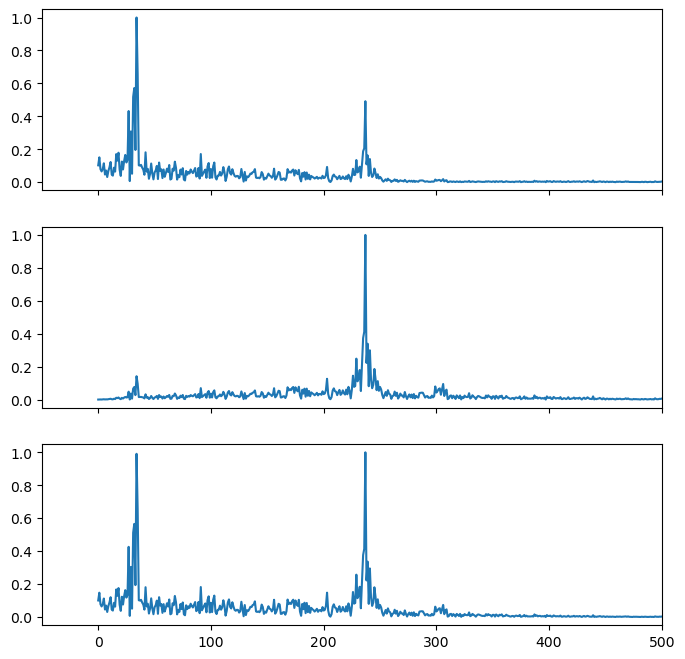

In [50]:
fourier = [np.abs(fft.fft(sol)) for sol in [x_sol,y_sol,z_sol]] 
fourier = [fou/np.max(fou) for fou in fourier]

samp = 1e5
tau = 1/samp # time interval

freq = fft.fftfreq(len(x_sol), tau)

fig,axs = plt.subplots(3,1,figsize=(8,8),sharex=True)

axs[0].set_xlim(-50,500, emit=True, auto=False)

for i in range(3): 
    axs[i].plot(freq[freq>=0], fourier[i][freq>=0])

plt.show()

## Lyapunov exponent

Retrieved from : https://arxiv.org/pdf/physics/0303077.pdf

Given two independent trajectories $X_1(t)$ and $X_2(t)$ of distinct
initial contiditions, $X_1(t_0)=X_0$, $X_2(t_0)=X_0+\delta X_0$, we can define the largest 
Lyapunov exponent as 

$||\delta X||=e^{\lambda_{max}t}||\delta X_0||$

where $||\cdot||$ is any definite norm.

In [ ]:
def max_lyapunov(X1,X2):
    X1_0,X2_0 = X1[0],X2[0]
    dX0 = np.linalg.norm(X1_0-X2_0)

    dX = [x1-x2 for x1,x2 in zip(X1,X2)]
    dX = np.linalg.norm(dX,axis=0)

    y = dX/dX0
    t = data[0][3]

    fit = linregress(t,y)
    m = fit.slope
    b = fit.intercept
    corr = fit.rvalue**2
    return y,m,b,corr

########## End of function defining ##########

R = 2730
C1 = 10e-9
C2 = 100e-9
L = 15e-3
F = 5
freq = 100

R2,R3 = 220,2200
R4,R6 = 22000,3300
A = 1000; E = 9

interior = [((A-1)*R2+R3)/(R2*(R2+(1+A)*R3))
            ,1/R2,
            (R2+(1+A)*R3)/(A*(R2+R3))*E]
exterior = [((A-1)*R4+R6)/(R4*(R4+(1+A)*R6))
            ,1/R4
            ,(R4+(1+A)*R6)/(A*(R4+R6))*E]

t_span = (0,0.02)
t_eval = np.linspace(*t_span,int(1e5))
 # No need to be so fine like here. 

# Recall that z is in Amperes (a large unit).
X1_0 = np.array([0,0,0])
X2_0 = np.array([1,3.1,1])

lyau = []
for freq in tqdm(np.linspace(10,300,10),leave=False):
    circ = [R,C1,C2,L,F,freq]

    data = []
    for X_0 in [X1_0,X2_0]:
        solution = solve_ivp(sys_DE,t_span,X_0,first_step=1e-7
                            ,args=[interior,exterior,circ]
                            ,t_eval=t_eval
                            )

        x1 = solution.y[0]
        y1 = solution.y[1]
        z1 = solution.y[2]
        t1 = solution.t

        data.append(np.array([x1,y1,z1,t1]))
    dX0 = norm(X1_0-X2_0)
    
    X1 = data[0][:3]
    X2 = data[1][:3]
    t = data[0][3]

    dX = norm(X1-X2,axis=0)
    y = np.log(dX/dX0)[:]

    # frc = int(len(y)/4)
    # t = t[:frc] ; y = y[:frc]

    fit = linregress(t,y)
    m = fit.slope
    b = fit.intercept
    corr = fit.rvalue**2
    
    lyau.append(y)
    frc = int(len(y)/9)
    plt.scatter(t[frc:],y[frc:],s=0.1,alpha=0.03)
    # X = np.array([0,max(t)])
    # plt.plot(X,m*X+b,label=f"{round(R,ndigits=1)}")

plt.legend(loc="upper right")

In [ ]:
X1,X2 = data[0][:3],data[1][:3]
t = data[0][3]

dX = [x1-x2 for x1,x2 in zip(X1,X2)]
dX = np.linalg.norm(dX,axis=0)

X1_0,X2_0 = X1[0],X2[0]
dX0 = np.linalg.norm(X1_0-X2_0)

y = np.log(dX/dX0)

fit = linregress(t,y)
m = fit.slope
b = fit.intercept
corr = fit.rvalue

y,m,b,coor = max_lyapunov(data[0][:3],data[1][:3])

print(m,coor)

plt.scatter(data[0][3],y,s=0.3)
X = np.array([0,max(t)])
plt.plot(X,m*X+b,color="orange")

# Lyapunov exponent from Rosenstein et al.

https://www.math.lsu.edu/clinic/4020clinic/GaitSP08/files/Rosenstein%20Lyapunov%20exponent.pdf

In [59]:
handle = open("collected_data/high_freq.pkl", 'rb')
data=pickle.load(handle)
handle.close()

amp = list(data.keys())
freq = list(data[amp[0]].keys())

data1 = {}
for F in amp:
    data1[F] = {}
    for f in freq:
        data1[F][f] = data[F][f][0]

F = amp[50]
f = freq[10]

t = data1[F][f][0]
dt = t[1]-t[0]
x = data1[F][f][1]


<class 'numpy.ndarray'> 8192
<class 'numpy.ndarray'> 100000


In [61]:
x = data1[F][f][1]
print(type(x),x.shape,len(x))
print(type(x_sol),x_sol.shape,len(x_sol))

<class 'numpy.ndarray'> (8192,) 8192
<class 'numpy.ndarray'> (100000,) 100000


In [10]:
import statsmodels.api as sm
from scipy.spatial.distance import cdist

frac = 10
# int(len(x_sol)/10)
x = x_sol[::frac]
t = time[::frac]
dt = t[1]-t[0]

n = 3; 
m = 2*n+2 # >2n
N = len(t)

# Find reconstruction delay. 
autocor = sm.tsa.acf(x)
J = np.argmin(autocor[autocor/autocor[0] > 1-1/np.e])

M = N-(m-1)*J

# Find reconstructed trajectory matrix
X = np.array([x[i:i+(m-1)*J] for i in range(M)])
T = np.array([t[i:i+(m-1)*J] for i in range(M)])

# Find mean frequency.
magnitude_spectrum = np.abs(np.fft.fft(x))
f_domn = np.argmax(magnitude_spectrum)/N
f_mean = f_domn/dt

# Apply time constraint. 
msk = cdist(T,T, metric='euclidean') > 1/f_mean
msk = np.where(msk)

pair_norm = cdist(X,X, metric='euclidean')

# Exclude all Xj,X\hat{j} pairs under the time constraint.
d0 = np.full(pair_norm.shape, np.nan)
d0[msk] = pair_norm[msk]

closest = np.nanargmin(d0,axis=0)

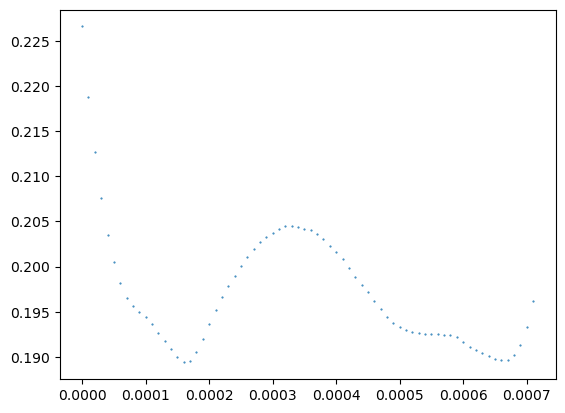

In [11]:
di =[]
for i in range((m-1)*J)[:-5]:
    dj = []
    for j in range(M):
        deviation = np.array(norm(X[j][i]-X[closest[j]][i]))
        dj.append(deviation+1)
    di.append(np.mean(np.log(dj)))

plt.plot(range(len(di))*dt,di,'o',markersize=0.5)